In [20]:
import pymc as pm
import pandas as pd

client_data = pd.DataFrame({
    "client": ["Client_A", "Client_B", "Client_C"],
    "trials": [3000, 5, 10],
    "successes": [900, 0, 10]  # Huge extremes for small clients
})


with pm.Model() as model:
    # Hyperpriors: global conversion rate and its concentration
    mu = pm.Beta("mu", alpha=1, beta=1)
    kappa = pm.HalfNormal("kappa", sigma=1)

    # Convert to alpha/beta parameters for individual Beta distributions
    alpha = pm.Deterministic("alpha", mu * kappa)
    beta = pm.Deterministic("beta", (1 - mu) * kappa)

    # Each client's true rate is drawn from the global Beta
    theta = pm.Beta("theta", alpha=alpha, beta=beta, shape=3)

    # Observed successes for each client
    obs = pm.Binomial("obs", 
                      n=client_data["trials"].values, 
                      p=theta, 
                      observed=client_data["successes"].values)

    # Sampling
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, kappa, theta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
from scipy.stats import beta
import arviz as az
import numpy as np

# Observed data
trials = [3000, 5, 10]
successes = [900, 0, 10]
clients = ["Client A", "Client B", "Client C"]

# Prior
alpha_prior = 1
beta_prior = 1

for i in range(3):
    alpha_post = alpha_prior + successes[i]
    beta_post = beta_prior + trials[i] - successes[i]
    
    # Posterior mean
    mean = alpha_post / (alpha_post + beta_post)
    
    # Draw samples to estimate HDI
    samples = beta.rvs(alpha_post, beta_post, size=10000)
    hdi_bounds = az.hdi(samples, hdi_prob=0.94)

    print(f"{clients[i]}:")
    print(f"  Mean: {mean:.4f}")
    print(f"  94% HDI: [{hdi_bounds[0]:.4f}, {hdi_bounds[1]:.4f}]")


Client A:
  Mean: 0.3001
  94% HDI: [0.2849, 0.3163]
Client B:
  Mean: 0.1429
  94% HDI: [0.0000, 0.3792]
Client C:
  Mean: 0.9167
  94% HDI: [0.7773, 1.0000]


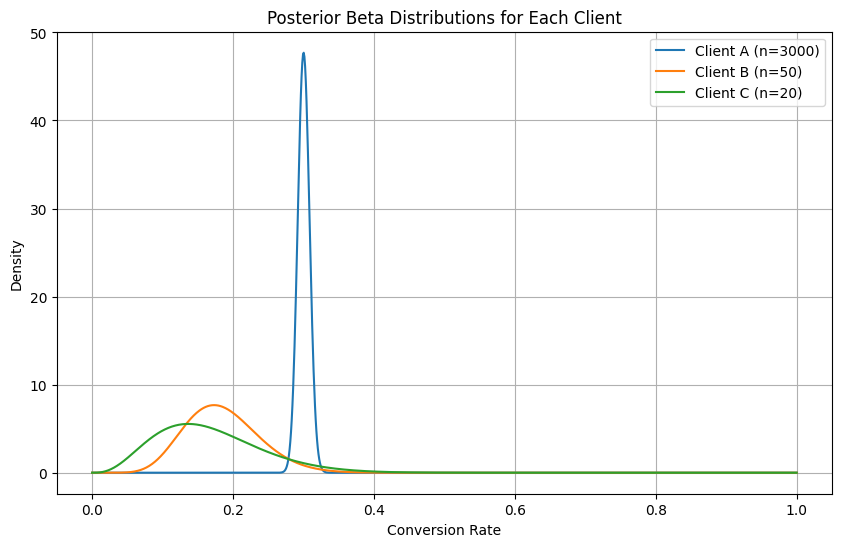

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Observed data
trials = [3000, 50, 20]
successes = [900, 8, 2]
clients = ["Client A", "Client B", "Client C"]

# Prior: Beta(1, 1) = uniform
alpha_prior = 2
beta_prior = 2

# Create x-axis for plotting
x = np.linspace(0, 1, 1000)

plt.figure(figsize=(10, 6))

for i in range(3):
    alpha_post = alpha_prior + successes[i]
    beta_post = beta_prior + trials[i] - successes[i]
    y = beta.pdf(x, alpha_post, beta_post)
    plt.plot(x, y, label=f"{clients[i]} (n={trials[i]})")

plt.title("Posterior Beta Distributions for Each Client")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
